In [1]:
import glob,random,os,datetime,sys,argparse,time
import numpy as np
import matplotlib.pyplot as plt

import torchvision
import torch
import torch.nn as nn
import torch.nn.init as init
from torch.utils.data import Dataset,DataLoader
import torch.optim as optim
from torch.optim.lr_scheduler import MultiStepLR
import torch.nn.functional as F

from tqdm import tqdm

from skimage.metrics import peak_signal_noise_ratio as psnr
from skimage.metrics import structural_similarity as ssim

## Usefull functions 

In [2]:
def log(*args, **kwargs):
    print('\r',datetime.datetime.now().strftime("%Y-%m-%d %H:%M:%S:"), *args, **kwargs)
    sys.stdout.flush()


def results_show(image1,image2,image3,ssim_scores,psnr_scores, figsize=(100,100)):
    """Permet de visualiser l'efficacité du modèle.
    
    - image 1 : image bruitée
    - image 2 : image débruitée
    - image 3 : vérité terrain"""
    psnr1,psnr2 = psnr_scores
    ssim1,ssim2 = ssim_scores

    f, (ax1, ax2, ax3) = plt.subplots(1, 3,figsize=figsize)

    ax1.imshow(image1)
    ax1.set_title('Image Bruitée'+'\n'+f'PSNR = {psnr1}'+'\n'+f'SSIM = {ssim1}',fontsize = 10)
    ax1.axis('off') 

    ax2.imshow(image2)
    ax2.set_title('Image Débruitée'+'\n'+f'PSNR = {psnr2}'+'\n'+f'SSIM = {ssim2}',fontsize = 10)
    ax2.axis('off')

    ax3.imshow(image3)
    ax3.set_title('Vérité Terrain',fontsize = 10)
    ax3.axis('off')
    plt.show()


def batch_visualisation(batch_in):
    """permet d'extraire les images liées au batch en entrée pour pouvoir calculer des scores ou l'afficher
    
    - batch_in : batch de taille 1 à traiter
    - batch_out : image numpy convertie"""
    batch_out = batch_in.squeeze(0).permute(1, 2, 0)
    batch_out = batch_out.cpu()
    batch_out = batch_out.detach().numpy().astype(np.float32)

    return batch_out


def find_last_checkpoint(save_dir):
    """Trouve le model associé à l'entrainement proposé. Donne le denier epoch utilisé pour l'entrainer.
    
    - save_dir : chemin de sauvegarde du model.
    - initial_epoch : epoch à partir du quel commencer l'entrainement.
    - model_name : nom du model associé à l'entrainement choisi."""
    file_list = glob.glob(os.path.join(save_dir, 'model_*.pth'))
    initial_epoch = 0
    model_name = ''
    if file_list:

        for file_ in file_list:
            result = file_.split('_')[-1]
            result = result.replace('.pth','')
            result = result.replace('e','')
            try : 
                int(result)
            except :
                print("Models with wrong names are detected")
            else :  
                if int(result) > initial_epoch :
                    initial_epoch = int(result)
                    model_name = file_
                  
    return initial_epoch,model_name

## Data and models definitions

In [3]:

class DenoisingDataset(Dataset):
    """Dataset wrapping tensors.

    - data_path : chemin vers le dossier d'entrainement.
    - sigma : sigma choisi pour le bruitage.
    - transforms : transformations choisies pour l'augmentation de données.
    """
    def __init__(self,data_path,sigma,transforms = None):
        super(DenoisingDataset, self).__init__()
        self.file_list = glob.glob(data_path+'/*.png')
        self.sigma = sigma
        self.transform = transforms

    def __getitem__(self, index):
        batch_x = torchvision.io.read_image(self.file_list[index])
        batch_x = batch_x.float()/255.0

        if self.transform : 
            batch_x = self.transform(batch_x)
        if self.sigma == -1 : 
            self.sigma = random.randint(0,50)

        noise = torch.randn(batch_x.size()).mul_(self.sigma/255.0)
        batch_y = batch_x + noise
        return batch_y, batch_x, noise

    def __len__(self):
        return len(self.file_list)


class PersonalDenoiserFataset(Dataset):
    """Dataset pour débruiter des images déjà bruitées. Seulement utile pour une mise en application sur des photos personelles.

    data_path : chemin vers la photo à traiter.
    """
    def __init__(self,data_path):
        super(PersonalDenoiserFataset, self).__init__()
        self.file_list = self.file_list = glob.glob(data_path+'/*.png')

    def __getitem__(self, index):
        batch_x = torchvision.io.read_image(self.file_list[index])
        batch_x = batch_x.float()/255.0

        return batch_x

    def __len__(self):
        return len(self.file_list)


class DnCNN(nn.Module):
    """Création du réseau de neurones."""
    def __init__(self, depth=7, n_channels=64, image_channels=3, use_bnorm=True, kernel_size=3):
        super(DnCNN, self).__init__()
        kernel_size = 3
        padding = 1
        layers = []

        layers.append(nn.Conv2d(in_channels=image_channels, out_channels=n_channels, kernel_size=kernel_size, padding=padding, bias=True))
        layers.append(nn.ReLU(inplace=True))
        for _ in range(depth-2):
            layers.append(nn.Conv2d(in_channels=n_channels, out_channels=n_channels, kernel_size=kernel_size, padding=padding, bias=False))
            layers.append(nn.BatchNorm2d(n_channels, eps=0.0001, momentum = 0.95))
            layers.append(nn.ReLU(inplace=True))
        layers.append(nn.Conv2d(in_channels=n_channels, out_channels=image_channels, kernel_size=kernel_size, padding=padding, bias=False))
        self.dncnn = nn.Sequential(*layers)
        self._initialize_weights()

    def forward(self, x):
        out = self.dncnn(x)
        return out

    def _initialize_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                init.orthogonal_(m.weight)
                if m.bias is not None:
                    init.constant_(m.bias, 0)
            elif isinstance(m, nn.BatchNorm2d):
                init.constant_(m.weight, 1)
                init.constant_(m.bias, 0)


def mean_std_db_calcul(images_dir):
    """Calculs des means et std de la data base d'entraînement (canal par canal)
    
    iamages_dir : dossier contenant les images d'entrainement"""
    current_file_directory = os.path.dirname(os.path.abspath(__file__))
    data_path = os.path.join(current_file_directory,images_dir)
    file_list = glob.glob(data_path+'/*.png')
    
    means_R,means_G,means_B = [],[],[]
    std_R,std_G,std_B = [],[],[]


    for file in file_list :
        image = torchvision.io.read_image(file)
        image = image.float()/255.0

        image_R = np.array(image[0,:,:])
        image_G = np.array(image[1,:,:])
        image_B = np.array(image[2,:,:])

        means_R.append(np.mean(image_R))
        means_G.append(np.mean(image_G))
        means_B.append(np.mean(image_B))

        std_R.append(np.std(image_R))
        std_G.append(np.std(image_G))
        std_B.append(np.std(image_B))
    
    def mean_l(tab):
        return sum(tab)/len(tab)
    
    means = [mean_l(means_R),mean_l(means_G),mean_l(means_B)]
    stds = [mean_l(std_R),mean_l(std_G),mean_l(std_B)]
    
    return means, stds

## Model training

===> Building model
resuming by loading epoch 1002
Training start


epoch progression:   0%|          | 0/3 [00:00<?, ?it/s]

epoch progression: 100%|██████████| 3/3 [00:10<00:00,  3.52s/it]


min_loss achieved for epoch 1003


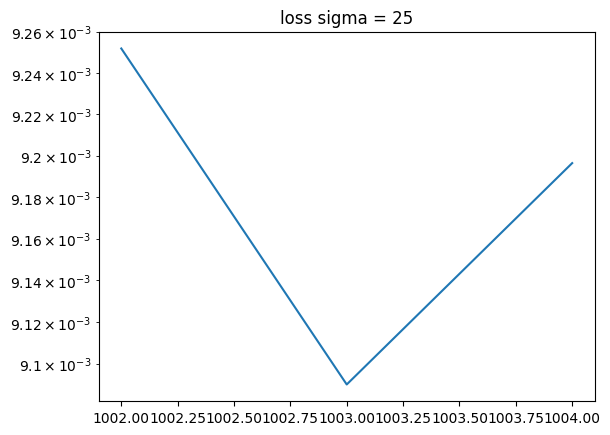

In [13]:
current_file_directory = os.getcwd()
parser = argparse.ArgumentParser(description='PyTorch DnCNN')
parser.add_argument('--sigma', default=25, type=int, help="Choix du sigma à utliser pour ,l'entrainement et le test. Attention un sigma de -1 rendra le sigma alétoire entre 0 et 50")
parser.add_argument('--image_channels', default=3,type=int, help="permet de choisir si les images traitée sont en rgb ou en niveau de gris")

##Données d'entrainement
parser.add_argument('--train_data', default=os.path.join(current_file_directory,
                                                         'BSD68/Train'), type=str, help='path of train data')
#Paramètre de sauvegarde
parser.add_argument('--model_dir', default=os.path.join(current_file_directory,
                                                        'Models/models_rgb/sigma_25'), help='directory of the model')
parser.add_argument('--loss_dir', default=os.path.join(current_file_directory,
                                                       'losses/loss'), help='directory of the loss plot')
parser.add_argument('--model', default='DnCNN', type=str, help='choose a type of model')
args, unknown = parser.parse_known_args()


###Choix des hyper_paramètres
training_batch_size = 1
training_nb_epoch = 1005
training_learning_rate = 1e-3
training_patch_size = 35

training_network = DnCNN(image_channels=args.image_channels)
training_optimizer = optim.Adam(training_network.parameters(), lr=training_learning_rate)
training_criterion = F.mse_loss
training_scheduler = MultiStepLR(training_optimizer, milestones=[training_nb_epoch/2], gamma=0.1) 

mean_db = [0.4273080293308286, 0.4416487863396897, 0.3839654446963002] 
std_db = [0.21955110505223274, 0.20601368640713832, 0.20300565298427553]
training_transforms = torchvision.transforms.Compose([torchvision.transforms.Normalize(mean = mean_db,std = std_db),                                                      
                                                          torchvision.transforms.RandomResizedCrop(size =training_patch_size,antialias=None),
                                                          torchvision.transforms.RandomHorizontalFlip(),
                                                          torchvision.transforms.RandomVerticalFlip(),
                                                          torchvision.transforms.RandomRotation(30)
                                                          ])


def model_training(network,optimizer,criterion,scheduler,nb_epoch,patch_size,batch_size,transforms) :
    """Entraînement et enregistement du modèle avec les options mises en paramètre
    
    network : type de réseau à entraîner
    optimizer : optimseur choisi pour l'optimisation
    criterion : critère choisi pour l'optimisation
    scheduler : opérateur de changement de learning rate choisi pour l'entraînement
    nb_epoch : nombre d'epoch maximal de l'entraînement
    patch_size : taille des patch des images d'entraînement
    batch_size : taille des batch utilisée pour l'optimisation"""
    print('===> Building model')
    

    model = network
    initial_epoch,model_name = find_last_checkpoint(save_dir=args.model_dir) 
    if initial_epoch > 0:
        print('resuming by loading epoch %03d' % initial_epoch)
        model = torch.load(model_name)
    else :
        print('Starting training form epoch 0')
    model.train()

   
    DDataset = DenoisingDataset(data_path=args.train_data,sigma = args.sigma,transforms=transforms)
    

    cuda = torch.cuda.is_available()
    if cuda:
        model = model.cuda()
        criterion = criterion.cuda()

    loss_evolution =[]
    min_epoch = initial_epoch
    print("Training start")
    for start,epoch in enumerate(tqdm(range(initial_epoch,nb_epoch), desc="epoch progression",leave=True)):
        
        DLoader = DataLoader(dataset=DDataset,batch_size=batch_size, shuffle=True)
        epoch_loss = 0

        for n_count,(batch_y, batch_x, noise) in enumerate(DLoader):
                
                if cuda:
                    batch_x, batch_y,noise = batch_x.cuda(), batch_y.cuda(),noise.cuda()

                optimizer.zero_grad()
                loss = criterion(model(batch_y), noise)
                epoch_loss += loss.item()
                loss.backward()
                optimizer.step()
        
        scheduler.step()

        epoch_loss = (epoch_loss/n_count)
        loss_evolution.append(epoch_loss)

        if start == 0 : 
             min_loss = epoch_loss
        elif epoch_loss < min_loss:
             min_epoch = epoch
             min_loss = epoch_loss
             torch.save(model,os.path.join(args.model_dir,f'model_c{args.image_channels}_s{args.sigma}_e{epoch}.pth'))

    print(f"min_loss achieved for epoch {min_epoch}")
    return loss_evolution


loss_evolution = model_training(network=training_network,
                                optimizer=training_optimizer,
                                criterion=training_criterion,
                                scheduler=training_scheduler,
                                nb_epoch=training_nb_epoch,
                                patch_size=training_patch_size,
                                batch_size=training_batch_size,
                                transforms=training_transforms)


#Affichage de la courbe de loss obtenu lors de l'entrainement.
plt.figure()
plt.semilogy(range(training_nb_epoch-len(loss_evolution),training_nb_epoch),loss_evolution)
plt.title(f'loss sigma = {args.sigma}')
plt.savefig(args.loss_dir)

## Model test

In [14]:
current_file_directory = os.getcwd()
parser = argparse.ArgumentParser(description='PyTorch DnCNN')
parser.add_argument('--model_name', default='model_rgb_1.pth', type=str, help="Nom du model qu'on souhaite entrainer ou tester")
parser.add_argument('--sigma', default=25, type=int, help="Choix du sigma à utliser pour ,l'entrainement et le test. Attention un sigma de -1 rendra le sigma alétoire entre 0 et 50")
parser.add_argument('--model_dir', default=os.path.join(current_file_directory,'Models/')
                    , type = str, help='directory of the model')
parser.add_argument('--test_data', default=os.path.join(current_file_directory,'/Projet/Data_rgb/Train')
                    , type=str, help='path of test data')
parser.add_argument('--visualisation',default=0,type=int,help="Choisi d'afficher les images débruitée ou non")
args, unknown = parser.parse_known_args()


def model_test() :
    """Fonction de test sur la base de données en paramètre du réseau utilisé. Il est possible de visualiser les résultats obtenus
    avec le paramètre visualisation
    
    psnr_noise_images,psnr_denoise_images : scores psnr des images bruitées et débruitées
    ssim_noise_images,ssim_denoise_images : scores ssim des images bruitées et débruitées
    denoising_time : temps de calcul pour le modèle utilisé
    """
    psnr_noise_images = []
    psnr_denoise_images = []
    ssim_noise_images = []
    ssim_denoise_images = []
    denoising_time = []

    cuda = torch.cuda.is_available()
    model = torch.load(os.path.join(current_file_directory,args.model_dir,args.model_name))

    if cuda :
        torch.cuda.synchronize()
        model.cuda()
        log('load trained model on gpu')
    else :
        log('load trained model on cpu')

    model.eval()
    DDataset = DenoisingDataset(data_path=os.path.join(current_file_directory,args.test_data)
                                    ,sigma = args.sigma)
    DLoader = DataLoader(dataset=DDataset,batch_size=1, shuffle=True)

    with torch.no_grad():
        for batch_y, batch_x,_ in tqdm(DLoader,f" Chargement des images sig = {args.sig}"):

            if cuda :
                batch_x, batch_y= batch_x.cuda(), batch_y.cuda()
                
            #Denoising
            start_time = time.time()
            noise_predicted = model(batch_y)
            elapsed_time = time.time() - start_time
            denoising_time.append(elapsed_time)
            batch_predicted = batch_y - noise_predicted

            #Results transformations for calculs
            batch_x = batch_visualisation(batch_x)
            batch_y = batch_visualisation(batch_y)
            batch_predicted = batch_visualisation(batch_predicted)
            
            #PSNR calculs 
            psnr_noise = psnr(batch_x,batch_y,data_range = 1.0)
            psnr_denoise = psnr(batch_x,batch_predicted,data_range = 1.0)
            psnr_noise_images.append(psnr_noise)
            psnr_denoise_images.append(psnr_denoise)
            
            #SSIM calculs 
            ssim_index_noise,_ = ssim(batch_x,batch_y,channel_axis = -1,full=True)
            ssim_index_denoise,_ = ssim(batch_x,batch_predicted,channel_axis = -1,full=True)
            ssim_noise_images.append(ssim_index_noise)
            ssim_denoise_images.append(ssim_index_denoise)

            if args.visualisation :
                results_show(image1=batch_x,image2=batch_predicted,image3=batch_y,
                             psnr_scores=(psnr_noise,psnr_denoise),
                             ssim_scores=(ssim_index_noise,ssim_index_denoise))
               
    return  psnr_noise_images,psnr_denoise_images,ssim_noise_images,ssim_denoise_images,denoising_time


def photo_application(photo_path,model_path):
    """Mise en application du modèle pour des images déjà bruitées
    
    photo_path : chemin de la photo à débruitée
    model_path : chemin du modèle utilisé pour le débruitage"""

    model = torch.load(os.path.join(current_file_directory,model_path))

    model.eval()
    DDataset = PersonalDenoiserFataset(data_path=os.path.join(current_file_directory,photo_path)
                                    ,sigma = args.sigma)
    DLoader = DataLoader(dataset=DDataset,batch_size=1, shuffle=True)

    with torch.no_grad():
        for  batch_x,_ in tqdm(DLoader,f" Chargement des images sig = {args.sig}"):
                
            #Denoising
            noise_predicted = model(batch_x)
            batch_predicted = batch_x - noise_predicted

            #Results transformations for calculs
            batch_x = batch_visualisation(batch_x)
            batch_predicted = batch_visualisation(batch_predicted)
            
            #Display Results
            f, (ax1, ax2) = plt.subplots(1, 2)
            ax1.imshow(batch_x)
            ax1.set_title('Image de base')
            ax1.axis('off') 
            ax2.imshow(batch_predicted)
            ax2.set_title('Image Débruitée')
            ax2.axis('off')
               
    return  
